In [1]:
#! pip install --user folium
#! pip install --user geopandas

In [2]:
import folium
from folium import Marker
import geopandas as gpd

In [3]:
def make_poly(ul_lat, ul_lon):
    coord_list = []
    ul_lon_lat = [ul_lon, ul_lat]
    ur_lon_lat = [ul_lon + 10, ul_lat]
    lr_lon_lat = [ul_lon + 10, ul_lat - 10]
    ll_lon_lat = [ul_lon, ul_lat - 10]
    
    print (ul_lon_lat)
    coord_list.append(ul_lon_lat)
    print (ur_lon_lat)
    coord_list.append(ur_lon_lat)
    print (lr_lon_lat)
    coord_list.append(lr_lon_lat)
    print (ll_lon_lat)
    coord_list.append(ll_lon_lat)
    print (ul_lon_lat)
    coord_list.append(ul_lon_lat)
    return(coord_list)

In [4]:
ul_lon = -90
ul_lat = 50
coords = make_poly(ul_lat, ul_lon)
coords

[-90, 50]
[-80, 50]
[-80, 40]
[-90, 40]
[-90, 50]


[[-90, 50], [-80, 50], [-80, 40], [-90, 40], [-90, 50]]

In [5]:
polycs = []
polycs.append(coords)

In [6]:
import json
geos = []
for polyc in polycs:
    poly = {
        'type': 'Feature',
        'properties': {},
        'geometry': {
            'type': 'Polygon',
            'coordinates': [polyc]
        }
    }
    geos.append(poly)

geometries = {
    'type': 'FeatureCollection',
    'features': geos,
}

geo_str = json.dumps(geometries)

In [7]:
geo_str

'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-90, 50], [-80, 50], [-80, 40], [-90, 40], [-90, 50]]]}}]}'

In [8]:
#with open('great_lakes.geojson', 'w') as outfile:
 #   json.dump(json.dumps(geometries), outfile)

In [9]:
!ls

00-project-plan-notes.ipynb	      great1.tif
10-window-great-lakes-rasterio.ipynb  great_lakes.geojson


In [10]:
! cat great_lakes.geojson

{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-90,50],[-80,50],[-80,40],[-90,40],[-90,50]]]}}]}

In [11]:
# Show the geometry of scene vs AOI against a basemap
geoms = gpd.read_file('great_lakes.geojson')
m = folium.Map([50, -90], zoom_start=7, width=900, height=350, tiles='OpenStreetMap')
folium.GeoJson(geoms).add_to(m)
#m.add_child(Marker(location=[45.3676, -97.4048], popup='Waubay, South Dakota AOI', icon = folium.Icon(color = 'red')))
#folium.LatLngPopup().add_to(m)
m

In [12]:
print(geoms)

                                            geometry
0  POLYGON ((-90.00000 50.00000, -80.00000 50.000...


In [13]:
type (geoms)

geopandas.geodataframe.GeoDataFrame

In [14]:
geoms.bounds

,minx,miny,maxx,maxy
0,-90.0,40.0,-80.0,50.0


In [15]:
geoms.bounds.minx[0]

-90.0

In [16]:
lons=[geoms.bounds.minx[0], geoms.bounds.maxx[0]]
lons

[-90.0, -80.0]

In [17]:
lats=[geoms.bounds.miny[0], geoms.bounds.maxy[0]]
lats

[40.0, 50.0]

In [18]:
import numpy as np
import rasterio

xs = np.array(lons)
ys = np.array(lats)

#tif = '/vsis3_streaming/dev-et-data/compressed/NDVI_filled/2001/2001001.250_m_NDVI.tif'

tif = '/vsis3_streaming/dev-et-data/NDVI_filled/2001/2001001.250_m_NDVI.tif'
with rasterio.open(tif) as src:
    rows, cols = rasterio.transform.rowcol(src.transform, xs, ys)

In [19]:
rows

[4805, -1]

In [20]:
cols

[31509, 36315]

In [21]:
import rasterio as rio

In [22]:
%%time
import rasterio as rio

infile = '/vsis3_streaming/dev-et-data/compressed/NDVI_filled/2001/2001180.250_m_NDVI.tif'

outfile = 'great1.tif'
coordinates = (
    (-85, 45) , # lon, lat of ~centre of great lakes
)

# Your NxN window
N = 5120

# Open the raster
with rio.open(infile) as dataset:

    # Loop through your list of coords
    for i, (lon, lat) in enumerate(coordinates):

        # Get pixel coordinates from map coordinates
        py, px = dataset.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))

        # Build an NxN window
        window = rio.windows.Window(px - N//2, py - N//2, N, N)
        print(window)

        # Read the data in the window
        # clip is a nbands * N * N numpy array
        clip = dataset.read(window=window)

        # You can then write out a new file
        meta = dataset.meta
        meta['width'], meta['height'] = N, N
        meta['transform'] = rio.windows.transform(window, dataset.transform)

        with rio.open(outfile.format(i), 'w', **meta) as dst:
            dst.write(clip)

Pixel Y, X coords: 2402, 33912
Window(col_off=31352, row_off=-158, width=5120, height=5120)
CPU times: user 1min 44s, sys: 4min 59s, total: 6min 43s
Wall time: 7min 51s


In [23]:
! gdalinfo great1.tif

Driver: GTiff/GeoTIFF
Files: great1.tif
Size is 5120, 5120
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-90.328729573999979,50.328798707000082)
Pixel Size = (0.002081004500000,-0.002081004500000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -90.3287296,  50.3287987) ( 90d19'43.43"W, 50d19'43.68"N)
Lower Left  ( -90.3287296,  39.6740557) ( 90d19'43.43"W, 39d40'26.60"N)
Upper Right ( -79.6739865,  50.3287987) ( 79d40'26.35"W, 50d19'43.68"N)
Lower Right ( -79.6739865,  39.6740557) ( 79d40'26.35"W, 39d40'26.60"N)
Center      ( -85.0013581,  45.0014272) ( 85d 0' 4.89"W, 45d 0' 5.14"N)
Band 1 Block=5120x1 Type=Float32, ColorInterp=Gray
  NoData Value=-3.4028234663852886e+38


In [24]:
little_file = 'great1.tif'
with rio.open(little_file) as dataset:
    rst = dataset.read(1)

rst

array([[0.7242476 , 0.71418154, 0.70280945, ..., 0.6816107 , 0.67706347,
        0.6665214 ],
       [0.7242476 , 0.71418154, 0.70280945, ..., 0.6816107 , 0.67706347,
        0.6665214 ],
       [0.7245481 , 0.71519005, 0.70386606, ..., 0.6825295 , 0.67842716,
        0.6707726 ],
       ...,
       [0.8066329 , 0.8053451 , 0.8049925 , ..., 0.85164195, 0.8524943 ,
        0.8563308 ],
       [0.8011554 , 0.80281156, 0.804369  , ..., 0.84709144, 0.847865  ,
        0.85136247],
       [0.7945736 , 0.79632455, 0.7974534 , ..., 0.8412965 , 0.84199417,
        0.8451147 ]], dtype=float32)

In [25]:
#! pip install --user xarray

In [26]:
import xarray
my_tif = 'great1.tif'
my_at_xarray = xarray.open_rasterio(my_tif)

In [27]:
my_at_xarray

<xarray.DataArray (band: 1, y: 5120, x: 5120)>
[26214400 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 50.33 50.33 50.32 50.32 ... 39.68 39.68 39.68 39.68
  * x        (x) float64 -90.33 -90.33 -90.32 -90.32 ... -79.68 -79.68 -79.68
Attributes:
    transform:      (0.0020810045, 0.0, -90.32872957399998, 0.0, -0.002081004...
    crs:            +init=epsg:4326
    res:            (0.0020810045, 0.0020810045)
    is_tiled:       0
    nodatavals:     (-3.4028234663852886e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [28]:
my_at_xarray = my_at_xarray.squeeze().drop(labels='band')
my_at_xarray

<xarray.DataArray (y: 5120, x: 5120)>
[26214400 values with dtype=float32]
Coordinates:
  * y        (y) float64 50.33 50.33 50.32 50.32 ... 39.68 39.68 39.68 39.68
  * x        (x) float64 -90.33 -90.33 -90.32 -90.32 ... -79.68 -79.68 -79.68
Attributes:
    transform:      (0.0020810045, 0.0, -90.32872957399998, 0.0, -0.002081004...
    crs:            +init=epsg:4326
    res:            (0.0020810045, 0.0020810045)
    is_tiled:       0
    nodatavals:     (-3.4028234663852886e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

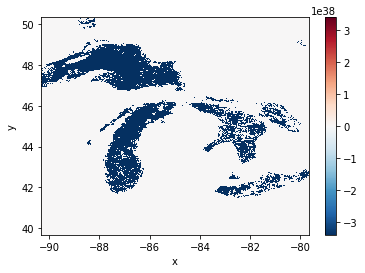

In [29]:
my_at_xarray.plot.imshow('x','y')

In [30]:
array = my_at_xarray.values


In [31]:
array

array([[0.7242476 , 0.71418154, 0.70280945, ..., 0.6816107 , 0.67706347,
        0.6665214 ],
       [0.7242476 , 0.71418154, 0.70280945, ..., 0.6816107 , 0.67706347,
        0.6665214 ],
       [0.7245481 , 0.71519005, 0.70386606, ..., 0.6825295 , 0.67842716,
        0.6707726 ],
       ...,
       [0.8066329 , 0.8053451 , 0.8049925 , ..., 0.85164195, 0.8524943 ,
        0.8563308 ],
       [0.8011554 , 0.80281156, 0.804369  , ..., 0.84709144, 0.847865  ,
        0.85136247],
       [0.7945736 , 0.79632455, 0.7974534 , ..., 0.8412965 , 0.84199417,
        0.8451147 ]], dtype=float32)

In [32]:
array.min()

-3.4028235e+38

In [33]:
array[(array < 0)] = 0

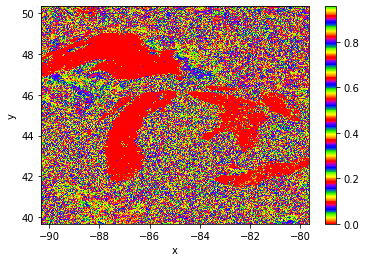

In [34]:
my_at_xarray.plot.imshow(cmap='prism')

In [35]:
cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r']

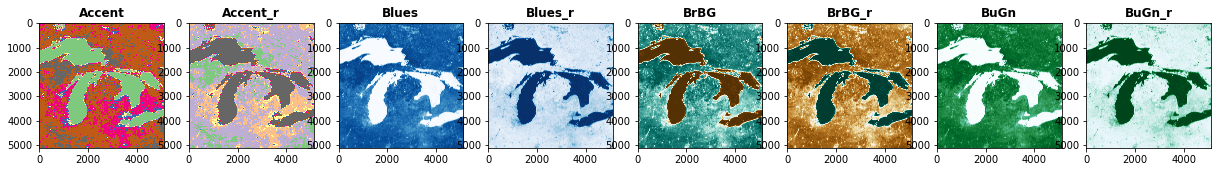

In [36]:
import matplotlib.pyplot as pyplot
from rasterio.plot import show
axs=()
fig, axs = pyplot.subplots(1,8, figsize=(21,21))
for i in range(0,8):
   show(array, ax=axs[i], cmap=cmaps[i], title=cmaps[i])
pyplot.show()

In [38]:
geoms.bounds

,minx,miny,maxx,maxy
0,-90.0,40.0,-80.0,50.0


In [39]:
%%time
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling

filepath=infile
left = geoms.bounds.minx[0]

right = geoms.bounds.maxx[0]

top = geoms.bounds.maxy[0]

bottom = geoms.bounds.miny[0]


with rasterio.open(filepath) as src:
    rst = src.read(1, window=from_bounds(left, bottom, right, top, src.transform))

CPU times: user 1min 37s, sys: 4min 42s, total: 6min 20s
Wall time: 7min 30s


In [40]:
rst[(rst < 0)] = 0

rst.shape

(4805, 4805)

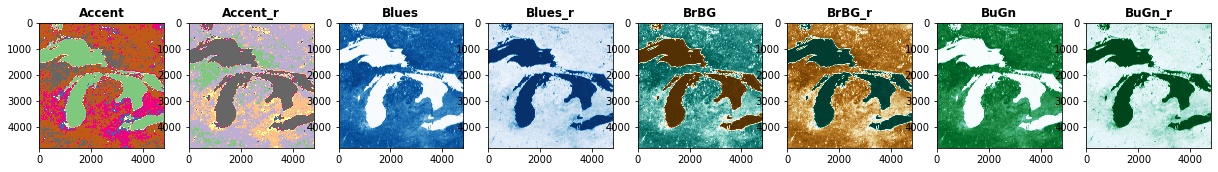

In [41]:

axs=()
fig, axs = pyplot.subplots(1,8, figsize=(21,21))
for i in range(0,8):
   show(rst, ax=axs[i], cmap=cmaps[i], title=cmaps[i])
pyplot.show()